In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import timedelta
from os import walk
from tensorflow import keras

plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
data_dir = "./Dados_StoAndre"
start_date = "16/12/2019"
header_names = ["hour", "kwh_h", "ch1", "ch2", "ch3", "ch4", "ch5", "ch6", "ch7", "ch8", "ch9", "ch10", "tem_h", "avgT", "minT", "maxT"]
files = []

for (_, _, filenames) in walk(data_dir):
    files.extend(filenames)
    break

time_series = pd.date_range(start=start_date, periods=24*len(files) - 13, freq='H')

hist_data = pd.DataFrame()
for i in range(len(files)):
    file = files[i]
    df = pd.read_csv(data_dir + '/' + file, header=None, names=header_names, delim_whitespace=True)
    hist_data = pd.concat([hist_data, df])

hist_data = hist_data.set_index(time_series)
hist_data

,hour,kwh_h,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,tem_h,avgT,minT,maxT
2019-12-16 00:00:00,0,kwh_h,0.324,0.000,0.000,0.000,0.328,0.007,0.0,0.0,0.324,0.336,tem_h,27.3,27.2,27.3
2019-12-16 01:00:00,1,kwh_h,0.231,0.002,0.001,0.000,0.241,0.017,0.0,0.0,0.232,0.259,tem_h,27.1,27.1,27.2
2019-12-16 02:00:00,2,kwh_h,0.264,0.000,0.003,0.001,0.274,0.012,0.0,0.0,0.265,0.290,tem_h,27.0,26.9,27.1
2019-12-16 03:00:00,3,kwh_h,0.137,0.000,0.000,0.001,0.146,0.011,0.0,0.0,0.138,0.158,tem_h,26.8,26.6,26.9
2019-12-16 04:00:00,4,kwh_h,0.164,0.000,0.000,0.000,0.176,0.010,0.0,0.0,0.165,0.186,tem_h,26.5,26.4,26.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-14 06:00:00,6,kwh_h,0.157,0.001,0.001,0.000,0.165,0.011,0.0,0.0,0.157,0.177,tem_h,24.1,24.0,24.2
2020-01-14 07:00:00,7,kwh_h,0.137,0.002,0.000,0.000,0.151,0.023,0.0,0.0,0.139,0.174,tem_h,24.0,24.0,24.1
2020-01-14 08:00:00,8,kwh_h,0.484,0.293,0.568,0.000,0.217,0.026,0.0,0.0,0.777,0.811,tem_h,24.1,24.0,24.3
2020-01-14 09:00:00,9,kwh_h,0.292,0.061,0.000,0.119,0.241,0.023,0.0,0.0,0.352,0.384,tem_h,24.4,24.2,24.6


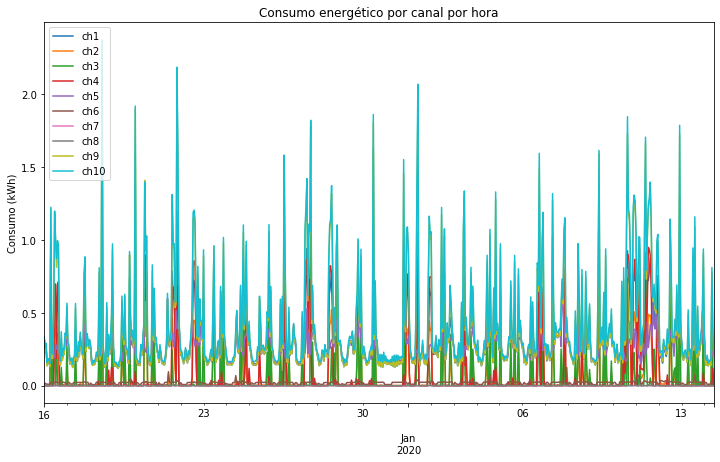

In [3]:
hist_data.loc[:, 'ch1':'ch10'].plot()
plt.title('Consumo energético por canal por hora')
plt.ylabel('Consumo (kWh)')
plt.legend(loc="upper left")

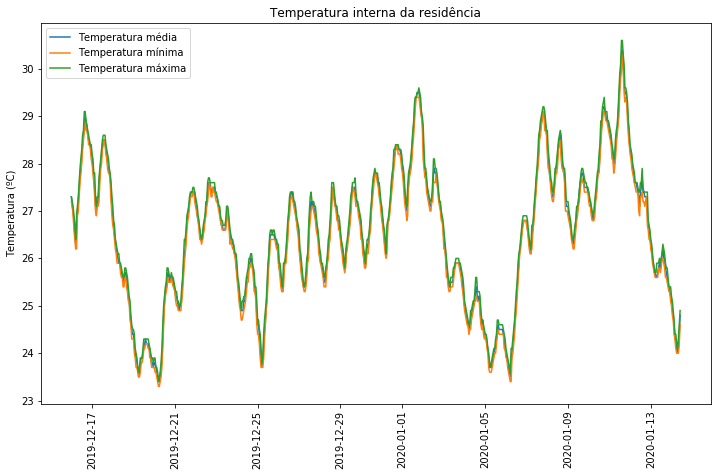

In [4]:
plt.plot(hist_data.index, hist_data['avgT'], label='Temperatura média')
plt.plot(hist_data.index, hist_data['minT'], label='Temperatura mínima')
plt.plot(hist_data.index, hist_data['maxT'], label='Temperatura máxima')
plt.title('Temperatura interna da residência')
plt.ylabel('Temperatura (ºC)')
plt.xticks(rotation=90)
plt.legend(loc="upper left")

In [5]:
print('Correlação entre canais e temperatura média:')
for i in range(1, 11):
    print(hist_data['ch' + str(i)].corr(hist_data['avgT']) * 100)

Correlação entre canais e temperatura média:
27.104618669970847
22.29577018599883
0.7321128746806882
34.017063157530906
21.07214981408716
23.349872714114888
12.388903033791117
17.544496881530165
25.55682524475588
26.069201386270045


# Naive Forecast 1
cons(t) = cons(t-1)

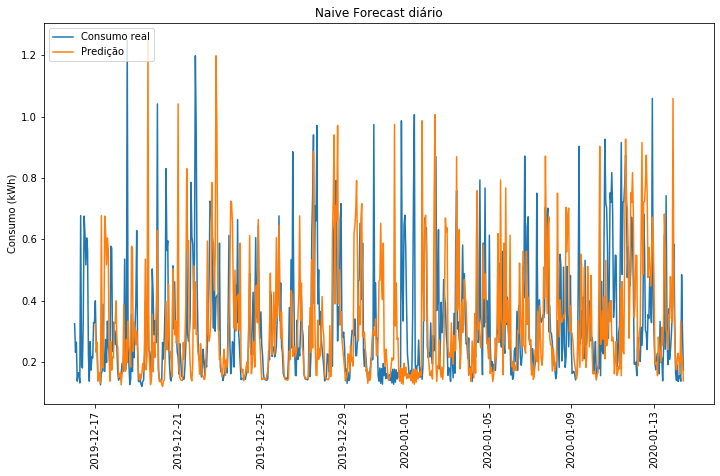

In [6]:
naive_forecast = hist_data.head(-24)
naive_forecast.index = naive_forecast.index + timedelta(days=1)

plt.plot(hist_data.index, hist_data['ch1'], label='Consumo real')
plt.plot(naive_forecast.index, naive_forecast['ch1'], label='Predição')
plt.title('Naive Forecast diário')
plt.ylabel('Consumo (kWh)')
plt.xticks(rotation=90)
plt.legend(loc="upper left")

In [7]:
print(keras.metrics.mean_squared_error(hist_data[24:]['ch1'], naive_forecast['ch1']).numpy())
print(keras.metrics.mean_absolute_error(hist_data[24:]['ch1'], naive_forecast['ch1']).numpy())
print(keras.metrics.mean_absolute_percentage_error(hist_data[24:]['ch1'], naive_forecast['ch1']).numpy())

0.05198570131771596
0.14771888726207905
46.60072391340908


# Naive Forecast 2
cons(t) = cons(t-7)

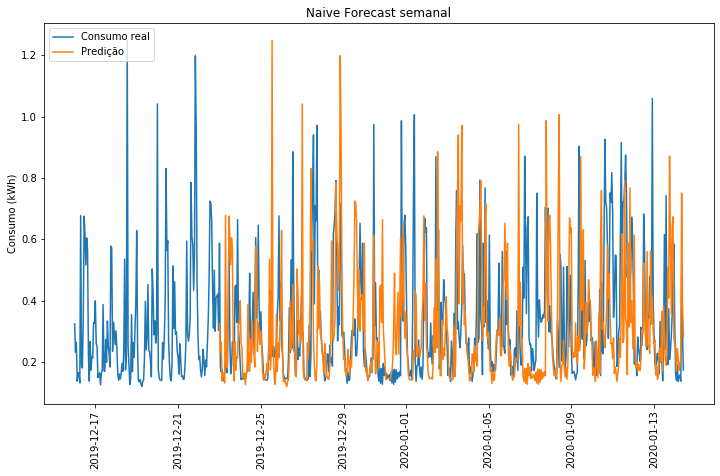

In [8]:
naive_forecast = hist_data.head(-24*7)
naive_forecast.index = naive_forecast.index + timedelta(days=7)

plt.plot(hist_data.index, hist_data['ch1'], label='Consumo real')
plt.plot(naive_forecast.index, naive_forecast['ch1'], label='Predição')
plt.title('Naive Forecast semanal')
plt.ylabel('Consumo (kWh)')
plt.xticks(rotation=90)
plt.legend(loc="upper left")

In [9]:
print(keras.metrics.mean_squared_error(hist_data[24*7:]['ch1'], naive_forecast['ch1']).numpy())
print(keras.metrics.mean_absolute_error(hist_data[24*7:]['ch1'], naive_forecast['ch1']).numpy())
print(keras.metrics.mean_absolute_percentage_error(hist_data[24*7:]['ch1'], naive_forecast['ch1']).numpy())

0.054693641929499076
0.15859183673469393
48.997391382198316


# Moving Average
cons(t) = (consumo - consumo semana passada) + MA(consumo semana passada)

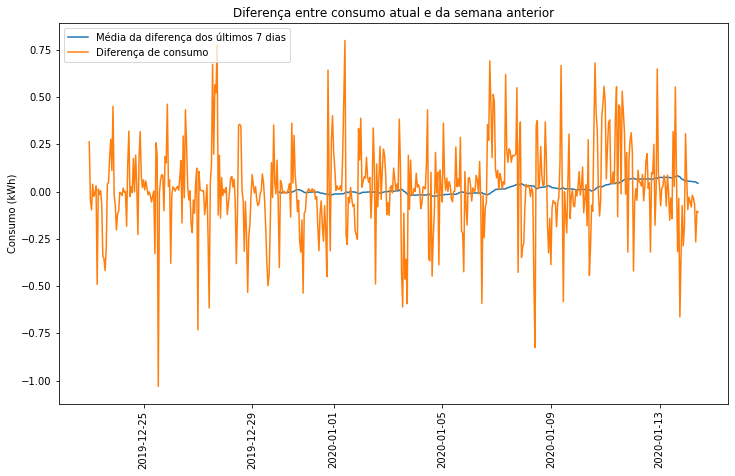

In [10]:
diff = hist_data['ch1'].subtract(naive_forecast['ch1']).tail(-24*7)

def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return pd.DataFrame(data=forecast, index=series.tail(-24*7).index, columns=['ch1'])

ma_diff = moving_average_forecast(diff, 24*7)
plt.plot(ma_diff.index, ma_diff['ch1'], label='Média da diferença dos últimos 7 dias')
plt.plot(diff.index, diff, label='Diferença de consumo')
plt.title('Diferença entre consumo atual e da semana anterior')
plt.ylabel('Consumo (kWh)')
plt.xticks(rotation=90)
plt.legend(loc="upper left")

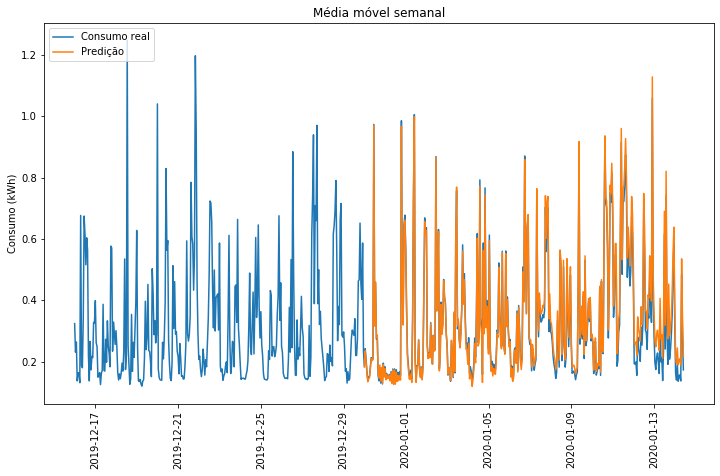

In [11]:
ma_forecast = ma_diff['ch1'].add(hist_data['ch1'].tail(-24*14))
plt.plot(hist_data.index, hist_data['ch1'], label='Consumo real')
plt.plot(ma_forecast.index, ma_forecast, label='Predição')
plt.title('Média móvel semanal')
plt.ylabel('Consumo (kWh)')
plt.xticks(rotation=90)
plt.legend(loc="upper left")

In [12]:
print(keras.metrics.mean_squared_error(hist_data[24*14:]['ch1'], ma_forecast).numpy())
print(keras.metrics.mean_absolute_error(hist_data[24*14:]['ch1'], ma_forecast).numpy())

0.001089365019008502
0.023823899371069178


# Neural Network


In [13]:
split_time = 20*24
train_set = hist_data['ch1'][:split_time]
valid_set = hist_data['ch1'][split_time:]

window_size = 16
batch_size = 32
shuffle_buffer_size = 1000

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [25]:
dataset = windowed_dataset(train_set, window_size, batch_size, shuffle_buffer_size)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([tf.keras.layers.Dense(12, input_dim=window_size, activation='relu'),
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.Dense(1)])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
15/15 [==============================] - 1s 50ms/step - loss: 0.0746 - mae: 0.3331
Epoch 2/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0758 - mae: 0.3331
Epoch 3/100
15/15 [==============================] - 0s 12ms/step - loss: 0.0742 - mae: 0.3331
Epoch 4/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0748 - mae: 0.3331
Epoch 5/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0750 - mae: 0.3331
Epoch 6/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0752 - mae: 0.3331
Epoch 7/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0744 - mae: 0.3331
Epoch 8/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0739 - mae: 0.3331
Epoch 9/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0757 - mae: 0.3330
Epoch 10/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0743 - mae: 0.3330
Epoch 11/100
15/15 [==============================] -

15/15 [==============================] - 0s 9ms/step - loss: 0.0419 - mae: 0.2149
Epoch 87/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0396 - mae: 0.2046
Epoch 88/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0386 - mae: 0.1938
Epoch 89/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0357 - mae: 0.1836
Epoch 90/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0321 - mae: 0.1739
Epoch 91/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0286 - mae: 0.1649
Epoch 92/100
15/15 [==============================] - ETA: 0s - loss: 0.0491 - mae: 0.160 - 0s 8ms/step - loss: 0.0290 - mae: 0.1568
Epoch 93/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0273 - mae: 0.1507
Epoch 94/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0257 - mae: 0.1464
Epoch 95/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0239 - mae: 0.1436
Epoch 96/100
15/15 [=====

[1e-08, 0.001, 0, 0.1]

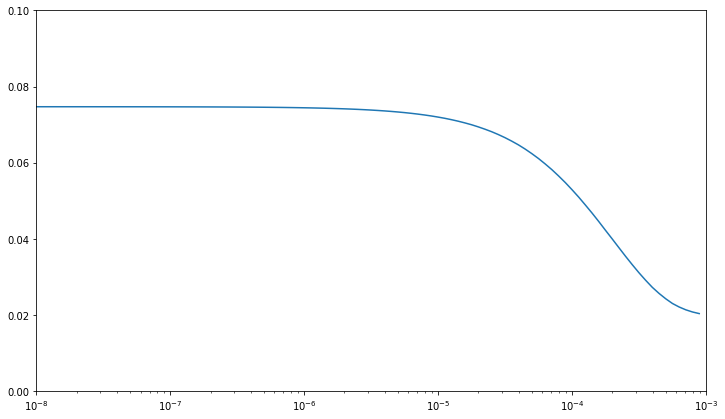

In [29]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 0.1])

In [30]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9))
model.fit(dataset,epochs=750,verbose=0)

In [31]:
forecast = []

for time in range(len(hist_data) - window_size):
    forecast.append(model.predict(hist_data['ch1'][time:time + window_size].values[np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

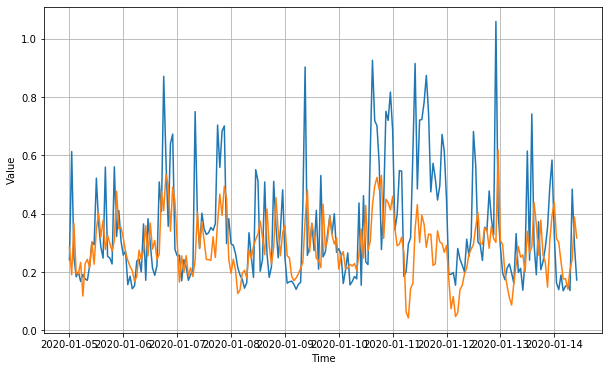

In [32]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))

plot_series(valid_set.index, valid_set)
plot_series(valid_set.index, results)

In [33]:
print(tf.keras.metrics.mean_squared_error(valid_set, results).numpy())
print(tf.keras.metrics.mean_absolute_error(valid_set, results).numpy())
print(tf.keras.metrics.mean_absolute_percentage_error(valid_set, results).numpy())

0.033636227
0.13082963
34.954517
